# **Wprowadzenie**


Projekt koncentruje się na analizie chemicznej próbek wina białego i czerwonego w celu wykrywania fałszerstw. Wykorzystuje algorytmy klasyfikacji, takie jak maszyna wektorów nośnych (SVM) i lasy losowe, do przewidywania, czy wino jest prawdziwe czy fałszywe na podstawie właściwości chemicznych. Analiza danych obejmuje przygotowanie, eksplorację, standaryzację i podział zbioru danych, a także optymalizację modeli i porównanie ich skuteczności.

### Wczytanie bibliotek


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


### Wczytanie danych, sprawdzenie danych, podstawowe statystyki

In [2]:
file_path = 'C:/Users/Admin/Desktop/wine_fraud.csv'
df = pd.read_csv(file_path)

print(df.head())

# Podstawowe statystyki
print(df.describe())

# Sprawdzenie brakujących danych
missing_data = df.isnull().sum()
print("Liczba brakujących danych w poszczególnych kolumnach:")
print(missing_data)


   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality type  
0      9.4   Legit  red  
1      9.8   Legit  red  
2      9

### Utworzenie wykresu słupkowego ilości wystąpień kategorii dotyczącej atrybutu warunkowego

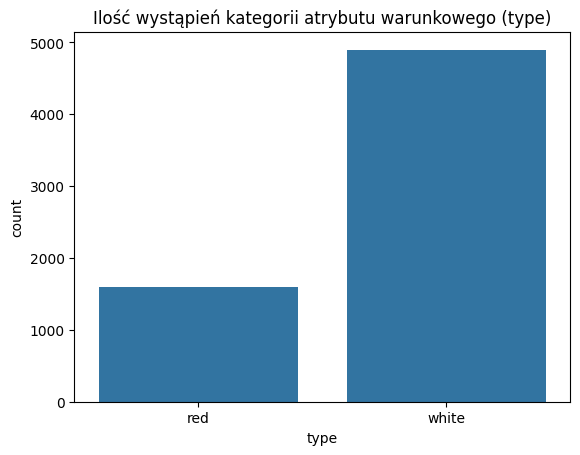

In [3]:

sns.countplot(x='type', data=df)
plt.title('Ilość wystąpień kategorii atrybutu warunkowego (type)')
plt.show()


### Różnice między winem czerwonym i białym w przypadkach fałszerstwa

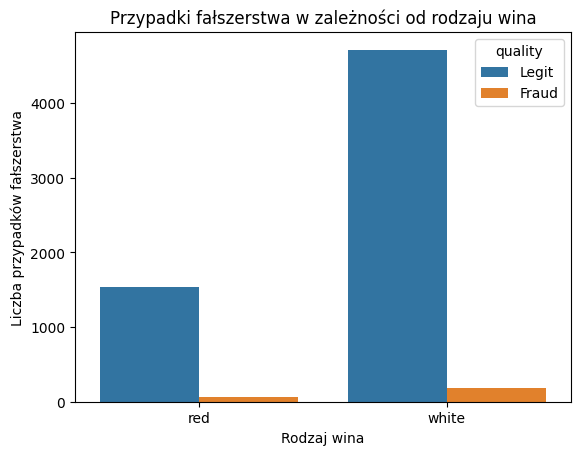

In [4]:
sns.countplot(x='type', hue='quality', data=df)
plt.title('Przypadki fałszerstwa w zależności od rodzaju wina')
plt.xlabel('Rodzaj wina')
plt.ylabel('Liczba przypadków fałszerstwa')
plt.show()

### Procent win czerwonych i białych, które są fałszywe

In [5]:
false_red_wine = df[(df['type'] == 'red') & (df['quality'] != 'Legit')].shape[0]
false_white_wine = df[(df['type'] == 'white') & (df['quality'] != 'Legit')].shape[0]

total_red_wine = df[df['type'] == 'red'].shape[0]
total_white_wine = df[df['type'] == 'white'].shape[0]

percentage_false_red = (false_red_wine / total_red_wine) * 100
percentage_false_white = (false_white_wine / total_white_wine) * 100

print(f"Procent fałszywych win czerwonych: {percentage_false_red:.2f}%")
print(f"Procent fałszywych win białych: {percentage_false_white:.2f}%")

Procent fałszywych win czerwonych: 3.94%
Procent fałszywych win białych: 3.74%


### Korelacja między różnymi cechami chemicznymi wina, a jakością wina

C:\Users\Admin\AppData\Local\Temp\ipykernel_14776\149693722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chemical_quality['quality'] = df_chemical_quality['quality'].apply(lambda x: 0 if x == 'Legit' else 1)


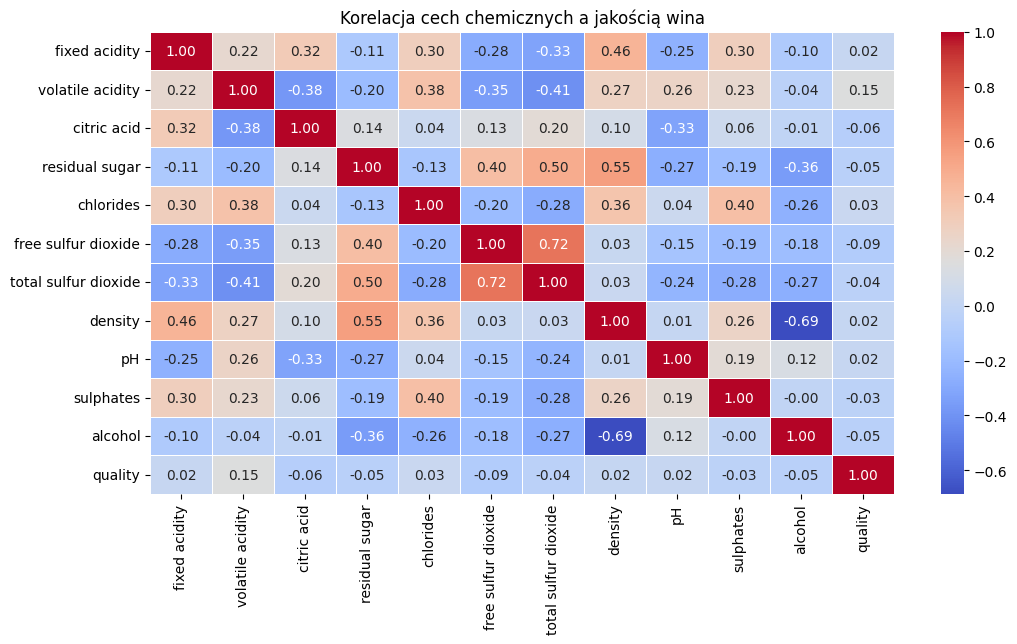

In [6]:
chemical_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                     'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
df_chemical_quality = df[chemical_columns]

# Zamiana kolumny jakości na zmienną binarną (0 - Legit, 1 - Fraud)
df_chemical_quality['quality'] = df_chemical_quality['quality'].apply(lambda x: 0 if x == 'Legit' else 1)

# Korelacja między cechami chemicznymi a jakością wina
correlation_matrix = df_chemical_quality.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korelacja cech chemicznych a jakością wina')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_14776\4028789880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chemical_quality['quality'] = df_chemical_quality['quality'].apply(lambda x: 0 if x == 'Legit' else 1)


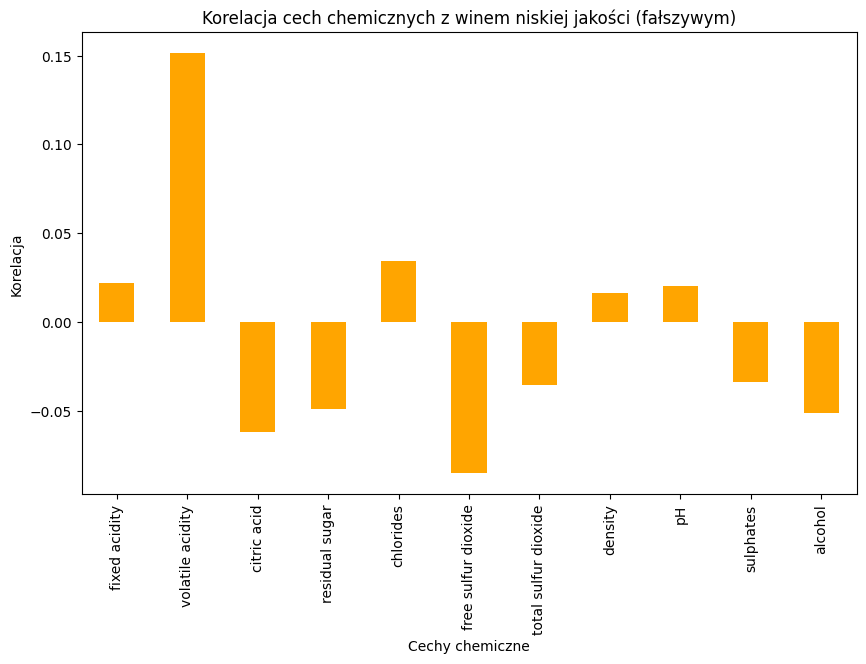

In [7]:
# Wybór tylko kolumn numerycznych i cech chemicznych
chemical_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                     'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
df_chemical_quality = df[chemical_columns]

# Zamiana kolumny jakości na zmienną binarną (0 - Legit, 1 - Fraud)
df_chemical_quality['quality'] = df_chemical_quality['quality'].apply(lambda x: 0 if x == 'Legit' else 1)

# Korelacja między cechami chemicznymi a jakością wina
correlation_matrix = df_chemical_quality.corr()

# Wybór korelacji z winem niskiej jakości
fraud_correlation = correlation_matrix['quality'].drop('quality')

# Utworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
fraud_correlation.plot(kind='bar', color='orange')
plt.title('Korelacja cech chemicznych z winem niskiej jakości (fałszywym)')
plt.xlabel('Cechy chemiczne')
plt.ylabel('Korelacja')
plt.show()


### Zamiana kolumny kategorialnej dotyczącej rodzaju wina na zmienną fikcyjną


In [8]:
 # Utworzenie zmiennych fikcyjnych dla kolumny 'type'
df_with_dummies = pd.get_dummies(df, columns=['type'], drop_first=True)

# Wyświetlenie pierwszych wierszy zmodyfikowanego DataFrame
print(df_with_dummies.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality  type_white  
0      9.4   Legit       False  
1      9.8   Legit  

### Podział danych na cechy (wartości numeryczne) oraz etykiety.

In [9]:
features = df_with_dummies.drop(['quality'], axis=1)
labels = df_with_dummies['quality']

print("Cechy (Features):")
print(features.head())

print("\nEtykiety (Labels):")
print(labels.head())


Cechy (Features):
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  type_white  
0      9.4       False  
1      9.8       F

### Podział zbioru danych na treningowy i testowy, gdzie zbiór testowy stanowi 10% całego zbioru danych, random_state = 101.

In [10]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

print("Rozmiar zbioru treningowego:", X_train.shape)
print("Rozmiar zbioru testowego:", X_test.shape)


Rozmiar zbioru treningowego: (5847, 12)
Rozmiar zbioru testowego: (650, 12)


### Standaryzacja zbioru treningowego i testowego.


In [11]:
# Inicjalizacja obiektu StandardScaler
scaler = StandardScaler()

# Standaryzacja zbioru treningowego i testowego
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Zastosowanie maszyny wektorów nośnych**

In [12]:
# 2.1. Tworzenie modelu SVM
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)

# Wyświetlenie raportu z klasyfikacji oraz macierzy błędów dla modelu
predictions = svm_model.predict(X_test_scaled)
print("Raport z klasyfikacji:")
print(classification_report(y_test, predictions))
print("Macierz błędów:")
print(confusion_matrix(y_test, predictions))

Raport z klasyfikacji:
              precision    recall  f1-score   support

       Fraud       0.00      0.00      0.00        27
       Legit       0.96      1.00      0.98       623

    accuracy                           0.96       650
   macro avg       0.48      0.50      0.49       650
weighted avg       0.92      0.96      0.94       650

Macierz błędów:
[[  0  27]
 [  0 623]]


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

### Zastosowanie metody przesukiwania siatki w celu doboru optymalnych parametrów C oraz gamma


In [13]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Najlepsze parametry
best_params = grid_search.best_params_
print("\nNajlepsze parametry:")
print(best_params)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=   1.4s
[CV] END .....................................C=0.1, gamma=1; total time=   1.0s
[CV] END .....................................C=0.1, gamma=1; total time=   1.2s
[CV] END .....................................C=0.1, gamma=1; total time=   1.2s
[CV] END .....................................C=0.1, gamma=1; total time=   1.6s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.3s
[CV] END ..................................C=0.1, gamma=0.01; total time=   0.2s
[CV] END ..................................C=0.1

### Wyświetlenie raportu z klasyfikacji oraz macierzy błędów dla zoptymalizowanego modelu

In [14]:
predictions_optimal = grid_search.predict(X_test_scaled)
print("Raport z klasyfikacji (zoptymalizowany model):")
print(classification_report(y_test, predictions_optimal))
print("Macierz błędów (zoptymalizowany model):")
print(confusion_matrix(y_test, predictions_optimal))


Raport z klasyfikacji (zoptymalizowany model):
              precision    recall  f1-score   support

       Fraud       1.00      0.04      0.07        27
       Legit       0.96      1.00      0.98       623

    accuracy                           0.96       650
   macro avg       0.98      0.52      0.53       650
weighted avg       0.96      0.96      0.94       650

Macierz błędów (zoptymalizowany model):
[[  1  26]
 [  0 623]]


#### Mimo że precision i recall dla klasy "Fraud" są nadal niskie, zoptymalizowany model poprawił swoją zdolność do identyfikacji przypadków oszustw w porównaniu do niezoptymalizowanego modelu. Jakość klasyfikacji uległa zmianie, a zoptymalizowany model działa lepiej, zwłaszcza pod względem identyfikacji oszustw.

# **Model lasów losowych**

### Zastosowanie klasyfikatora lasów losowych

In [15]:
random_forest_model = RandomForestClassifier(random_state=101)
random_forest_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=101)

### Wyświetlenie raportu z klasyfikacji oraz macierz błędów na podstawie predykcji na zbiorze testowym

In [16]:
predictions_rf = random_forest_model.predict(X_test_scaled)
print("Raport z klasyfikacji (Las losowy):")
print(classification_report(y_test, predictions_rf))
print("Macierz błędów (Las losowy):")
print(confusion_matrix(y_test, predictions_rf))


Raport z klasyfikacji (Las losowy):
              precision    recall  f1-score   support

       Fraud       0.75      0.11      0.19        27
       Legit       0.96      1.00      0.98       623

    accuracy                           0.96       650
   macro avg       0.86      0.55      0.59       650
weighted avg       0.95      0.96      0.95       650

Macierz błędów (Las losowy):
[[  3  24]
 [  1 622]]


### Zastosowanie losowego przeszukiwania siatki dla optymalnych parametrów lasu losowego

In [17]:
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=101), param_distributions=param_dist_rf, n_iter=10, refit=True, verbose=2)
random_search_rf.fit(X_train_scaled, y_train)

# Najlepsze parametry
best_params_random_rf = random_search_rf.best_params_
print("\nNajlepsze parametry lasu losowego (losowe przeszukiwanie):")
print(best_params_random_rf)

# Utworzenie modelu lasu losowego z optymalnymi parametrami
optimal_random_rf_model = RandomForestClassifier(random_state=101, **best_params_random_rf)
optimal_random_rf_model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=99; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=99; total time=   3.0s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=99; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=99; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=3, min_samples_split=4, n_estimators=99; total time=   1.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   1.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   1.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.6s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50; total time=   0.7s
[CV] END max_depth=20, min_sa

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=73,
                       random_state=101)

# **Porównanie klasyfikatorów (SVM i lasu losowego)**

In [18]:
# Raport z klasyfikacji i macierz błędów dla SVM
print("Raport z klasyfikacji (SVM):")
print(classification_report(y_test, predictions_optimal))

# Predykcja za pomocą zoptymalizowanego modelu lasu losowego
predictions_optimal_rf = optimal_random_rf_model.predict(X_test_scaled)

# Raport z klasyfikacji i macierz błędów dla zoptymalizowanego modelu lasu losowego
print("\nRaport z klasyfikacji (Las losowy - zoptymalizowany model):")
print(classification_report(y_test, predictions_optimal_rf))

# Porównanie dokładności obu klasyfikatorów
accuracy_svm = accuracy_score(y_test, predictions_optimal)
accuracy_rf = accuracy_score(y_test, predictions_optimal_rf)

print(f"\nDokładność klasyfikatora SVM: {accuracy_svm}")
print(f"Dokładność klasyfikatora Lasu losowego: {accuracy_rf}")


Raport z klasyfikacji (SVM):
              precision    recall  f1-score   support

       Fraud       1.00      0.04      0.07        27
       Legit       0.96      1.00      0.98       623

    accuracy                           0.96       650
   macro avg       0.98      0.52      0.53       650
weighted avg       0.96      0.96      0.94       650


Raport z klasyfikacji (Las losowy - zoptymalizowany model):
              precision    recall  f1-score   support

       Fraud       1.00      0.07      0.14        27
       Legit       0.96      1.00      0.98       623

    accuracy                           0.96       650
   macro avg       0.98      0.54      0.56       650
weighted avg       0.96      0.96      0.95       650


Dokładność klasyfikatora SVM: 0.96
Dokładność klasyfikatora Lasu losowego: 0.9615384615384616


#### Na podstawie dokładności obu klasyfikatorów możemy stwierdzić, że oba modele są bardzo skuteczne w klasyfikacji, ze zbliżonymi wynikami. Klasyfikator Lasu Losowego osiągnął nieznacznie wyższą dokładność (96.15%) w porównaniu do klasyfikatora SVM (96%).

#### Porównując zoptymalizowane modele do niezoptymalizowanych, można zauważyć, że oba zoptymalizowane modele poprawiły recall dla klasy "Fraud", co oznacza, że identyfikują więcej rzeczywistych przypadków oszustw. Jednakże, recall dla klasy "Fraud" jest nadal stosunkowo niski, co sugeruje, że identyfikacja oszustw jest trudnym zadaniem w tym zbiorze danych. Jeśli porównujemy poprawę klasyfikacji względem klasyfikatora niezoptymalizowanego, to klasyfikator Lasów Losowych wykazał większą poprawę w recall dla klasy "Fraud" niż klasyfikator SVM.